# Demo

In [1]:
# Basic libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from PIL import Image

In [2]:
# Personalized modules
from preprocess.dataloader import AntibodiesTree
from preprocess.patches_utils import PatchesUtilities

from osgen.embedding import StyleExtractor
from osgen.utils import Utilities
from osgen.vae import VanillaVAE,VanillaEncoder
from osgen.base import BaseModel
from osgen.nn import *

/root/miniconda3/envs/biosgen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [3]:
# Directory where your tumor PNGs are stored
directory = '/root/BiOSGen/data/NKX3'

for filename in os.listdir(directory):
    if filename.endswith('.png') and 'NKX3' not in filename and 'NKX' in filename:
        new_filename = filename.replace('NKX', 'NKX3')
        old_path = os.path.join(directory, filename)
        new_path = os.path.join(directory, new_filename)
        os.rename(old_path, new_path)
        print(f'Renamed: {filename} -> {new_filename}')


In [4]:
# SRC antibodies
tree_src = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/HE",
    mask_dir = "/root/BiOSGen/data/tissue_masks/HE",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/HE"
)

# DST antibodies
tree_dst = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/NKX3",
    mask_dir = "/root/BiOSGen/data/tissue_masks/NKX3",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/NKX3"
)

# Print
print("Nb antibodies: ", tree_src.get_nb_antibodies())
print("Nb antibodies: ", tree_dst.get_nb_antibodies())

Nb antibodies:  248
Nb antibodies:  248


### Extract patches

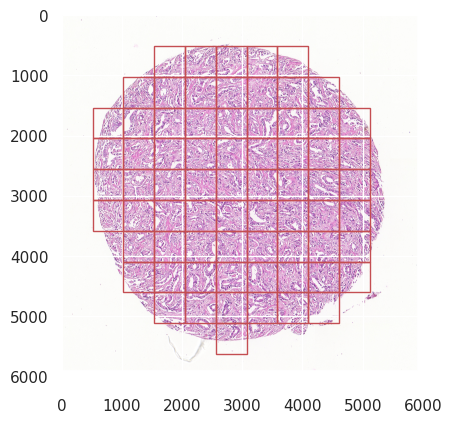

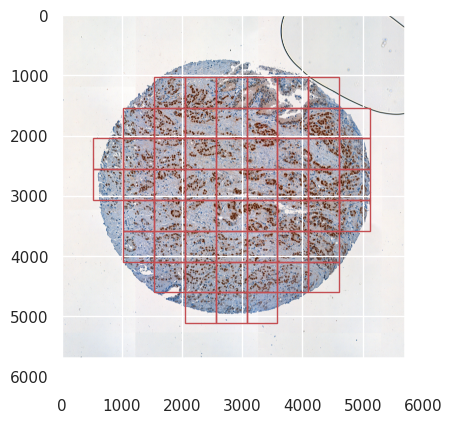

In [5]:
patches_src = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_src.antibodies[0])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[0]))),
)

patches_dst = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_dst.antibodies[0])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_dst.antibodies[0]))),
)

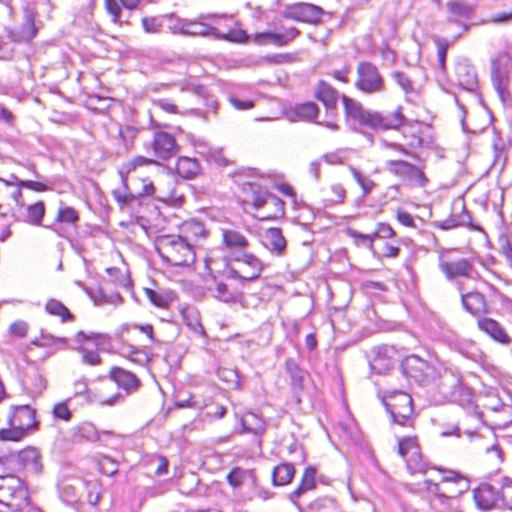

In [6]:
# Get patch to test
test_patch_src = patches_src[10]
Image.fromarray(test_patch_src)

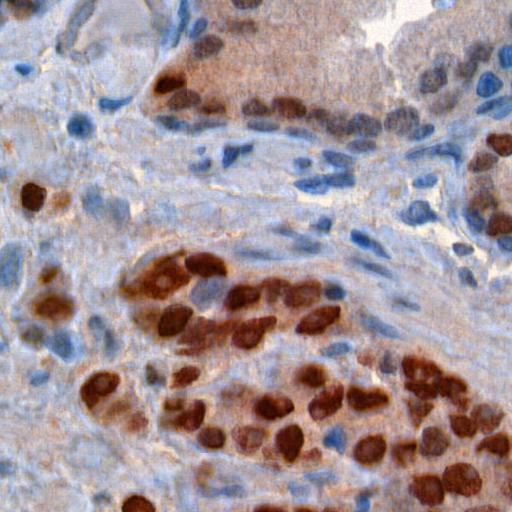

In [7]:
# Get patch to test
test_patch_dst = patches_dst[10]
Image.fromarray(test_patch_dst)

## Style extractor test

In [8]:
# Convert test patches to tensor
ut = Utilities()

test_patch_src_tensor = ut.convert_numpy_to_tensor(test_patch_src)
test_patch_dst_tensor = ut.convert_numpy_to_tensor(test_patch_dst)

print("test_patch_src_tensor shape: ", test_patch_src_tensor.shape)
print("test_patch_dst_tensor shape: ", test_patch_dst_tensor.shape)

test_patch_src_tensor shape:  torch.Size([1, 3, 512, 512])
test_patch_dst_tensor shape:  torch.Size([1, 3, 512, 512])


In [9]:
extractor = StyleExtractor()
style_emb = extractor(test_patch_dst_tensor)
print("out shape: ", style_emb.shape)

/root/miniconda3/envs/biosgen/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/biosgen/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


out shape:  torch.Size([1, 512, 64, 64])


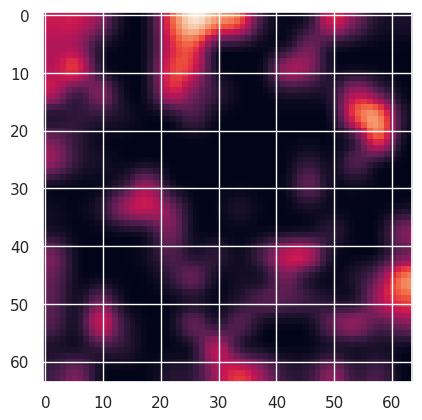

In [10]:
plt.imshow(style_emb[0, 0].detach().numpy())

## Full VAE test

In [11]:
# Define model parameters
in_channels = 3
latent_dim = 512  # you can adjust this
hidden_dims = [32, 64, 128, 256]  # same as your encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Create dummy test input (or use your real tensor)
# test_patch_src_tensor = torch.randn(1, 3, 512, 512).to(device)

# Convert input tensor to device
test_patch_src_tensor = test_patch_src_tensor.to('cuda')

# 3. Instantiate the model
vae = VanillaVAE(
    in_channels=3,
    latent_dim=64,  # You can choose a different latent dimension
    hidden_dims=[32, 64]
).to(device)

vae.eval()

# 4. Forward pass
with torch.no_grad():
    [mu, log_var] = vae.encode(test_patch_src_tensor)

# print("Input shape:", input_tensor.shape)
# print("Reconstructed shape:", reconstructed.shape)
print("Latent mu shape:", mu.shape)
print("Latent log_var shape:", log_var.shape)

# 5. Compute loss (optional)?
# loss_dict = vae.loss_function(reconstructed, input_tensor, mu, log_var, M_N=1.0)
# print("Losses:", loss_dict)

Latent mu shape: torch.Size([1, 64, 128, 128])
Latent log_var shape: torch.Size([1, 64, 128, 128])


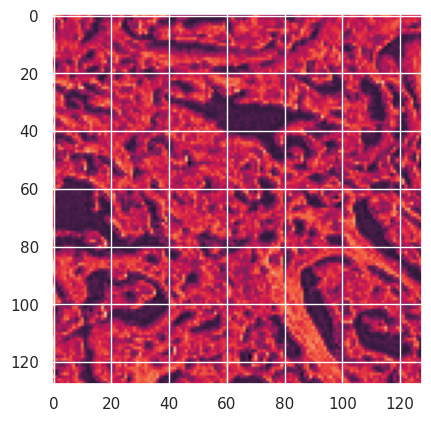

In [12]:
plt.imshow(mu[0][60].cpu().numpy())

## Encoder test

In [13]:
# Define model parameters
in_channels = 3
latent_dim = 512  # you can adjust this
hidden_dims = [32, 64, 128, 256]  # same as your encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Create dummy test input (or use your real tensor)
# test_patch_src_tensor = torch.randn(1, 3, 512, 512).to(device)

# Convert input tensor to device
test_patch_src_tensor = test_patch_src_tensor.to('cuda')

# 3. Instantiate the model
encoder = VanillaEncoder(
    in_channels=3,
    latent_dim=64,  # You can choose a different latent dimension
    hidden_dims=[32, 64, 128],  # same as your encoder,
    learned=True
).to(device)

vae.eval()

# 4. Forward pass
with torch.no_grad():
    encoded = encoder(test_patch_src_tensor)
print("Encoded shape:", encoded.shape)

Encoded shape: torch.Size([1, 64, 64, 64])


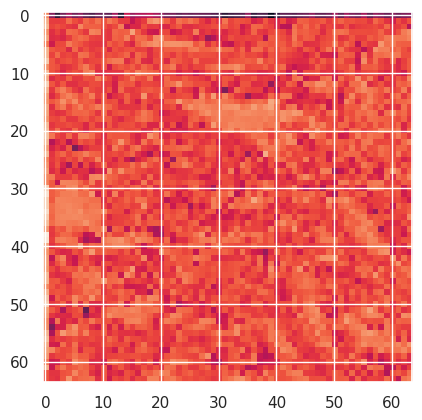

In [14]:
plt.imshow(encoded[0][1].cpu().numpy())

## U-Net model

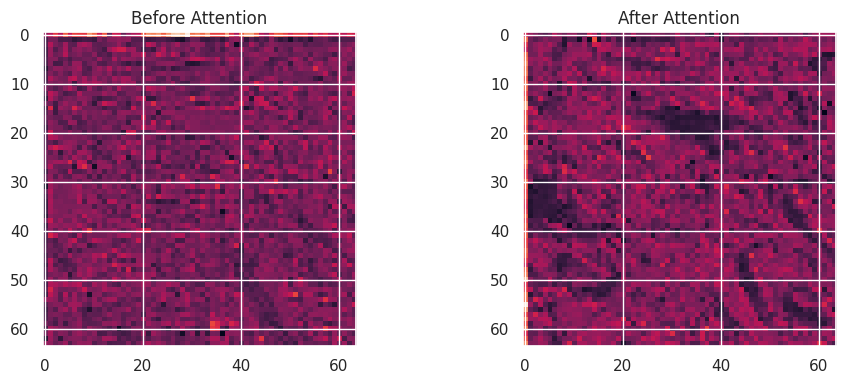

In [15]:
import torch.nn as nn
import matplotlib.pyplot as plt

# Simulate input
x = encoded  # [B, C, H, W]
original = x.clone()

# Flatten for attention
B, C, H, W = x.shape
x_flat = x.view(B, C, H * W).transpose(1, 2)     # [B, 4096, 64]
x_attn = x_flat.transpose(0, 1)                  # [4096, 1, 64]

# Multi-head attention
mha = nn.MultiheadAttention(embed_dim=64, num_heads=4, batch_first=False).cuda()
attn_output, _ = mha(x_attn, x_attn, x_attn)

# Reshape back
attn_output = attn_output.transpose(0, 1)        # [1, 4096, 64]
attn_output = attn_output.transpose(1, 2).view(B, C, H, W)

# Convert tensors to CPU numpy
original_img = original[0, 0].detach().cpu().numpy()  # Channel 0
attn_img = attn_output[0, 0].detach().cpu().numpy()   # Same channel after attention

# Plot before/after
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Before Attention")
# plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(attn_img)
plt.title("After Attention")
# plt.axis('off')

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Downsampled Image')

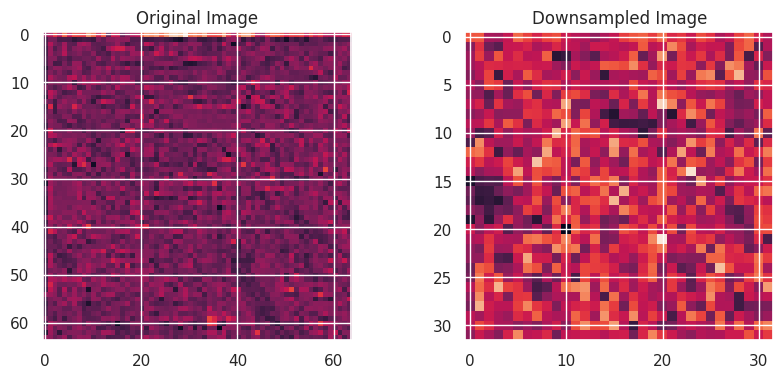

In [20]:
# Instantiate the module
downsample = Downsample(in_channels=64, use_conv=True).to('cuda')

# Create a test input tensor
x = encoded

# Run the forward pass
output = downsample(x)

# Visualize the output image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(x[0][0].cpu().detach().numpy())
plt.title("Original Image")
# Visualize the original image
plt.subplot(1, 2, 2)
plt.imshow(output[0][0].cpu().detach().numpy())
plt.title("Downsampled Image")

Original shape: torch.Size([1, 64, 64, 64])
Upsampled shape: torch.Size([1, 128, 128, 128])


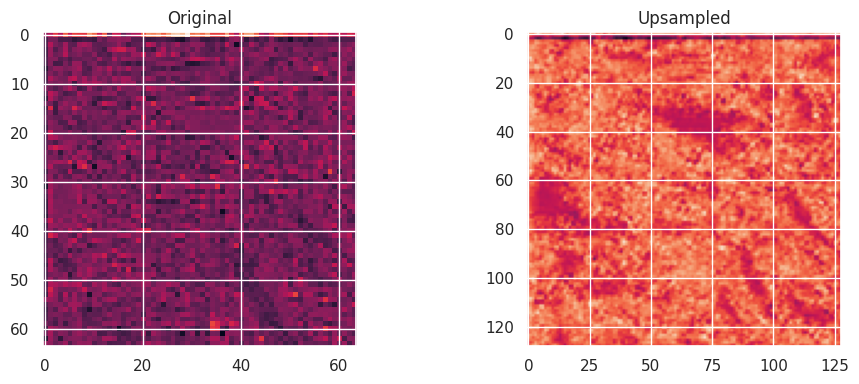

In [24]:
# Test Upsample
upsample = Upsample(in_channels=64, use_conv=True, out_channels=128).cuda()
x = encoded  # Example input
x = x.to('cuda')  # Move to GPU if needed
x_upsampled = upsample(x)
print("Original shape:", x.shape)
print("Upsampled shape:", x_upsampled.shape)
# Visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(x[0, 0].detach().cpu().numpy())  # Channel 0
plt.title("Original")
# plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_upsampled[0, 0].detach().cpu().numpy())  # Channel 0
plt.title("Upsampled")
# plt.axis('off')

plt.tight_layout()
plt.show()

In [25]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define parameters for ResBlock
in_channels = 64  # To match your tensor size
out_channels = 64  # Keep same output channels
emb_channels = 256  # Typical embedding dimension
dropout = 0.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lora_rank = 16

print(f"Using device: {device}")

# Create sample input tensor with size [1, 64, 64, 64]
x =encoded.to('cuda')
print(f"Input tensor shape: {x.shape}")

# Create sample timestep embedding
# Using a random timestep value between 0 and 1000
timestep = torch.tensor([500], device=device)
emb = timestep_embedding(timestep, emb_channels)
print(f"Embedding shape: {emb.shape}")

# Initialize ResBlock
resblock = ResBlock(
    emb_channels=emb_channels,
    dropout=dropout,
    in_channels=in_channels,
    out_channels=out_channels,
    use_scale_shift_norm=True,
    device=device,
    is_trainable=True,
    lora_rank=lora_rank
)
resblock.to(device)

# Forward pass
with torch.no_grad():
    output = resblock(x, emb)

print(f"Output tensor shape: {output.shape}")

# Check if output has the expected shape
assert output.shape == x.shape, f"Expected shape {x.shape} but got {output.shape}"

# Print some statistics about the output
print(f"Output mean: {output.mean().item()}")
print(f"Output std: {output.std().item()}")
print(f"Output min: {output.min().item()}")
print(f"Output max: {output.max().item()}")

print("ResBlock test completed successfully!")

Using device: cuda
Input tensor shape: torch.Size([1, 64, 64, 64])
Embedding shape: torch.Size([1, 256])
Output tensor shape: torch.Size([1, 64, 64, 64])
Output mean: -0.04704534634947777
Output std: 0.6482403874397278
Output min: -4.125555992126465
Output max: 4.529081344604492
ResBlock test completed successfully!


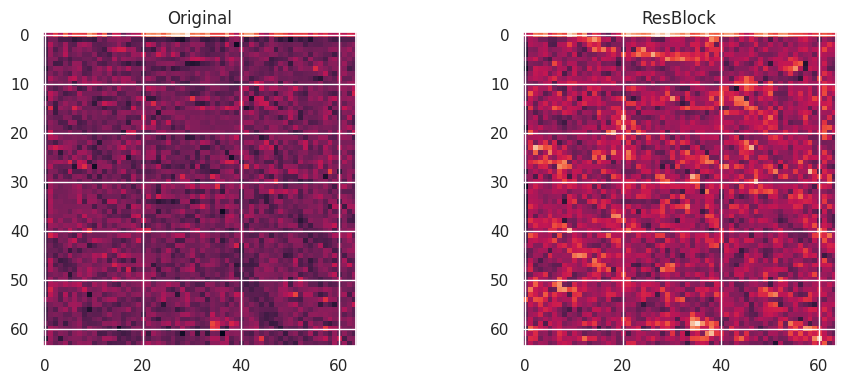

In [30]:
# Visualize output 
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(x[0, 0].detach().cpu().numpy())  # Channel 0
plt.title("Original")
# plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(output[0, 0].detach().cpu().numpy())  # Channel 0
plt.title("ResBlock")
# plt.axis('off')
plt.tight_layout()
plt.show()


In [31]:
output.shape

torch.Size([1, 64, 64, 64])

---

## Test  Test cross attention

In [28]:
import torch
import torch.nn as nn
from flash_attn import flash_attn_func

class FlashStyleCrossAttention(nn.Module):
    def __init__(self, z_dim=64, style_dim=512, heads=4):
        super().__init__()
        self.heads = heads
        self.head_dim = z_dim // heads
        
        # Ensure z_dim is divisible by heads
        assert z_dim % heads == 0, f"z_dim {z_dim} must be divisible by heads {heads}"
        
        self.to_q = nn.Linear(z_dim, z_dim, bias=False)
        self.to_k = nn.Linear(style_dim, z_dim, bias=False)
        self.to_v = nn.Linear(style_dim, z_dim, bias=False)
        self.out_proj = nn.Linear(z_dim, z_dim)
        
        self.scale = (self.head_dim) ** -0.5
        
    def forward(self, z, style):
        # Store original dtype for later conversion back
        original_dtype = z.dtype
        
        B, C, H, W = z.shape
        B, C, H1, W1 = style.shape
        
        z_flat = z.permute(0, 2, 3, 1).reshape(B, H * W, C)  # (B, HW, C)
        
        # Compute Q, K, V
        Q = self.to_q(z_flat)  # (B, HW, C)
        K = self.to_k(style)   # (B, N, C)
        V = self.to_v(style)   # (B, N, C)
        
        # Reshape for multi-head attention
        # flash_attn expects [batch_size, seq_len, num_heads, head_dim]
        Q = Q.view(B, H * W, self.heads, self.head_dim)
        K = K.view(B, H1 * W1, self.heads, self.head_dim)
        V = V.view(B, H1 * W1, self.heads, self.head_dim)
        
        # Convert to fp16 for flash attention
        # Use bf16 if available (more numerically stable than fp16)
        if torch.cuda.is_available() and torch.cuda.is_bf16_supported():
            dtype = torch.bfloat16
        else:
            dtype = torch.float16
            
        Q = Q.to(dtype)
        K = K.to(dtype)
        V = V.to(dtype)
        
        # Use flash_attn for cross-attention
        attn_output = flash_attn_func(
            Q, K, V,
            dropout_p=0.0,
            softmax_scale=self.scale,
            causal=False
        )  # (B, HW, heads, head_dim)
        
        # Convert back to original dtype
        attn_output = attn_output.to(original_dtype)
        
        # Reshape back to original dimensions
        attn_output = attn_output.reshape(B, H * W, C)
        out = self.out_proj(attn_output)
        out = out.view(B, H, W, C).permute(0, 3, 1, 2)  # (B, C, H, W)
        
        return out

# === TEST ===
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    z = output.to(device)       # (B, C, H, W)
    style = style_emb.to(device)      # (B, N_tokens, D_embed)
    
    model = FlashStyleCrossAttention(z_dim=64, style_dim=512, heads=4).to(device)
    
    # Enable autocast for mixed precision training
    # This is optional but recommended for broader compatibility
    with torch.cuda.amp.autocast(enabled=True):
        z_out = model(z, style)
    
    print(f"Input z shape:     {z.shape}")
    print(f"Input z dtype:     {z.dtype}")
    print(f"Style shape:       {style.shape}")
    print(f"Output z_out shape:{z_out.shape}")
    print(f"Output z_out dtype:{z_out.dtype}")
    print(f"Computation device: {z_out.device}")

/tmp/ipykernel_10951/4281285578.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


UnboundLocalError: local variable 'Q' referenced before assignment

In [32]:
import torch
import torch.nn as nn
from flash_attn import flash_attn_func

class FlashStyleCrossAttention(nn.Module):
    def __init__(self, z_dim=64, style_dim=512, heads=4):
        super().__init__()
        self.heads = heads
        self.head_dim = z_dim // heads
        
        # Ensure z_dim is divisible by heads
        assert z_dim % heads == 0, f"z_dim {z_dim} must be divisible by heads {heads}"
        
        self.to_q = nn.Linear(z_dim, z_dim, bias=False)
        self.to_k = nn.Linear(style_dim, z_dim, bias=False)
        self.to_v = nn.Linear(style_dim, z_dim, bias=False)
        self.out_proj = nn.Linear(z_dim, z_dim)
        
        self.scale = (self.head_dim) ** -0.5
        
    def forward(self, z, style):
        # Store original dtype for later conversion back
        original_dtype = z.dtype
        
        B, C, H, W = z.shape
        B, C_style, H_style, W_style = style.shape
        
        # Flatten z
        z_flat = z.permute(0, 2, 3, 1).reshape(B, H * W, C)  # (B, HW, C)
        
        # Flatten style
        style_flat = style.permute(0, 2, 3, 1).reshape(B, H_style * W_style, C_style)  # (B, HW, C_style)
        
        # Compute Q, K, V
        Q = self.to_q(z_flat)      # (B, HW, C)
        K = self.to_k(style_flat)  # (B, H_style*W_style, C)
        V = self.to_v(style_flat)  # (B, H_style*W_style, C)
        
        # Reshape for multi-head attention
        Q = Q.view(B, H * W, self.heads, self.head_dim)
        K = K.view(B, H_style * W_style, self.heads, self.head_dim)
        V = V.view(B, H_style * W_style, self.heads, self.head_dim)
        
        # Convert to fp16 or bf16 for flash attention
        if torch.cuda.is_available() and torch.cuda.is_bf16_supported():
            dtype = torch.bfloat16
        else:
            dtype = torch.float16
            
        Q = Q.to(dtype)
        K = K.to(dtype)
        V = V.to(dtype)
        
        # Use flash_attn for cross-attention
        attn_output = flash_attn_func(
            Q, K, V,
            dropout_p=0.0,
            softmax_scale=self.scale,
            causal=False
        )  # (B, HW, heads, head_dim)
        
        # Convert back to original dtype
        attn_output = attn_output.to(original_dtype)
        
        # Reshape back
        attn_output = attn_output.reshape(B, H * W, C)
        out = self.out_proj(attn_output)
        out = out.view(B, H, W, C).permute(0, 3, 1, 2)  # (B, C, H, W)
        
        return out

# === TEST ===
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    z = output.to(device)       # (B, C, H, W)
    style = style_emb.to(device)      # (B, N_tokens, D_embed)
    
    model = FlashStyleCrossAttention(z_dim=64, style_dim=512, heads=4).to(device)
    
    with torch.cuda.amp.autocast(enabled=True):
        z_out = model(z, style)
    
    print(f"Input z shape:     {z.shape}")
    print(f"Input z dtype:     {z.dtype}")
    print(f"Style shape:       {style.shape}")
    print(f"Output z_out shape:{z_out.shape}")
    print(f"Output z_out dtype:{z_out.dtype}")
    print(f"Computation device: {z_out.device}")


Input z shape:     torch.Size([1, 64, 64, 64])
Input z dtype:     torch.float32
Style shape:       torch.Size([1, 512, 64, 64])
Output z_out shape:torch.Size([1, 64, 64, 64])
Output z_out dtype:torch.float16
Computation device: cuda:0


/tmp/ipykernel_10951/1223076437.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Text(0.5, 1.0, 'Output')

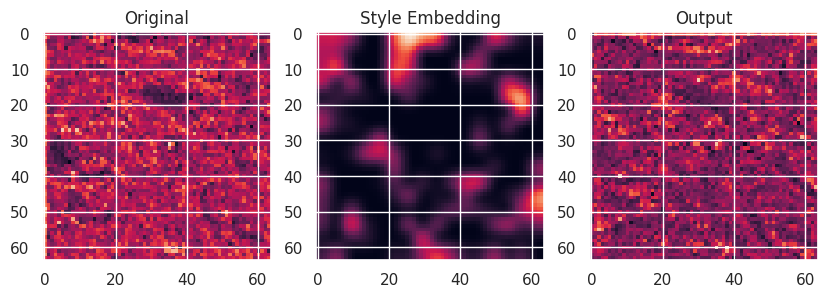

In [39]:
# visualize original and output
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(output[0, 51].detach().cpu().numpy())  # Channel 0
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(style_emb[0, 0].detach().cpu().numpy())  # Channel 0
plt.title("Style Embedding")
# plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(z_out[0][51].cpu().detach().numpy())  # Channel 0
plt.title("Output")

In [60]:
import torch
import torch.nn as nn
from flash_attn import flash_attn_func
import matplotlib.pyplot as plt
import numpy as np

class FlashStyleCrossAttention(nn.Module):
    def __init__(self, z_dim=64, style_dim=512, heads=4):
        super().__init__()
        self.heads = heads
        self.head_dim = z_dim // heads
        
        # Ensure z_dim is divisible by heads
        assert z_dim % heads == 0, f"z_dim {z_dim} must be divisible by heads {heads}"
        
        self.to_q = nn.Linear(z_dim, z_dim, bias=False)
        self.to_k = nn.Linear(style_dim, z_dim, bias=False)
        self.to_v = nn.Linear(style_dim, z_dim, bias=False)
        self.out_proj = nn.Linear(z_dim, z_dim)
        
        self.scale = (self.head_dim) ** -0.5
        
    def forward(self, z, style, return_attention=False):
        # Store original dtype for later conversion back
        original_dtype = z.dtype
        
        B, C, H, W = z.shape
        _, N, D = style.shape
        
        z_flat = z.permute(0, 2, 3, 1).reshape(B, H * W, C)  # (B, HW, C)
        
        # Compute Q, K, V
        Q = self.to_q(z_flat)  # (B, HW, C)
        K = self.to_k(style)   # (B, N, C)
        V = self.to_v(style)   # (B, N, C)
        
        # Reshape for multi-head attention
        # flash_attn expects [batch_size, seq_len, num_heads, head_dim]
        Q = Q.view(B, H * W, self.heads, self.head_dim)
        K = K.view(B, N, self.heads, self.head_dim)
        V = V.view(B, N, self.heads, self.head_dim)
        
        # If requesting attention weights, compute them before conversion to fp16/bf16
        # This is separate from the main computation path
        attention_weights = None
        if return_attention:
            # We'll compute the attention weights separately on CPU to avoid memory issues
            # and to not interfere with the flash_attn_func path
            Q_vis = Q.detach().cpu().float()
            K_vis = K.detach().cpu().float()
            
            # Compute attention scores for all heads
            # (B, HW, heads, head_dim) x (B, N, heads, head_dim)T -> (B, heads, HW, N)
            Q_vis = Q_vis.permute(0, 2, 1, 3)  # (B, heads, HW, head_dim)
            K_vis = K_vis.permute(0, 2, 1, 3)  # (B, heads, N, head_dim)
            
            # Compute attention scores
            attn_scores = torch.matmul(Q_vis, K_vis.transpose(-1, -2)) * self.scale  # (B, heads, HW, N)
            attention_weights = torch.softmax(attn_scores, dim=-1)  # (B, heads, HW, N)
        
        # Convert to fp16 for flash attention
        # Use bf16 if available (more numerically stable than fp16)
        if torch.cuda.is_available() and torch.cuda.is_bf16_supported():
            dtype = torch.bfloat16
        else:
            dtype = torch.float16
            
        Q = Q.to(dtype)
        K = K.to(dtype)
        V = V.to(dtype)
        
        # Use flash_attn for cross-attention
        attn_output = flash_attn_func(
            Q, K, V,
            dropout_p=0.0,
            softmax_scale=self.scale,
            causal=False
        )  # (B, HW, heads, head_dim)
        
        # Convert back to original dtype
        attn_output = attn_output.to(original_dtype)
        
        # Reshape back to original dimensions
        attn_output = attn_output.reshape(B, H * W, C)
        out = self.out_proj(attn_output)
        out = out.view(B, H, W, C).permute(0, 3, 1, 2)  # (B, C, H, W)
        
        if return_attention:
            return out, attention_weights
        return out

def visualize_attention(attention_weights, H, W, num_style_tokens):
    """
    Visualize attention weights as heatmaps
    
    Args:
        attention_weights: Tensor of shape (B, heads, H*W, N)
        H, W: Height and width of the spatial dimensions
        num_style_tokens: Number of style tokens
    """
    # Average across heads and take first batch
    avg_attention = attention_weights[0].mean(dim=0)  # (H*W, N)
    
    # Reshape to spatial dimensions for better visualization
    spatial_attention = avg_attention.reshape(H, W, num_style_tokens)
    
    # Create a figure for overall attention patterns
    plt.figure(figsize=(15, 10))
    
    # Plot average attention to each style token
    token_importance = avg_attention.mean(dim=0)
    plt.subplot(2, 1, 1)
    plt.bar(range(num_style_tokens), token_importance.numpy())
    plt.title('Average Attention per Style Token')
    plt.xlabel('Style Token Index')
    plt.ylabel('Average Attention')
    
    # Plot heatmap of spatial positions attending to style tokens
    plt.subplot(2, 1, 2)
    plt.imshow(avg_attention, aspect='auto', cmap='viridis')
    plt.title('Attention Heatmap: Spatial Positions (rows) vs Style Tokens (columns)')
    plt.xlabel('Style Token Index')
    plt.ylabel('Spatial Position (flattened H*W)')
    plt.colorbar(label='Attention Weight')
    
    plt.tight_layout()
    plt.savefig('attention_overview.png')
    plt.close()
    
    # Create spatial attention maps for individual tokens
    num_tokens_to_show = min(6, num_style_tokens)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i in range(num_tokens_to_show):
        token_map = spatial_attention[:, :, i].numpy()
        ax = axes[i]
        im = ax.imshow(token_map, cmap='viridis')
        ax.set_title(f'Style Token {i}')
        ax.axis('off')
        plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.savefig('spatial_attention_maps.png')
    plt.close()
    
    print("Visualization complete! Check 'attention_overview.png' and 'spatial_attention_maps.png'")

# === TEST ===
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    z = output.to(device)       # (B, C, H, W)
    style = style_emb.to(device)      # (B, N_tokens, D_embed)
    
    model = FlashStyleCrossAttention(z_dim=64, style_dim=512, heads=4).to(device)
    
    # Enable autocast for mixed precision training
    with torch.cuda.amp.autocast(enabled=True):
        # First run - normal forward pass
        z_out = model(z, style)
        
        # Second run - get attention weights for visualization
        z_out_vis, attention_weights = model(z, style, return_attention=True)
    
    print(f"Input z shape:     {z.shape}")
    print(f"Input z dtype:     {z.dtype}")
    print(f"Style shape:       {style.shape}")
    print(f"Output z_out shape:{z_out.shape}")
    print(f"Output z_out dtype:{z_out.dtype}")
    print(f"Computation device: {z_out.device}")
    
    # Visualize attention patterns
    H, W = z.shape[2], z.shape[3]
    visualize_attention(attention_weights, H, W, style.shape[1])


/tmp/ipykernel_9958/2829699619.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Input z shape:     torch.Size([1, 64, 64, 64])
Input z dtype:     torch.float32
Style shape:       torch.Size([1, 18, 512])
Output z_out shape:torch.Size([1, 64, 64, 64])
Output z_out dtype:torch.float16
Computation device: cuda:0
Visualization complete! Check 'attention_overview.png' and 'spatial_attention_maps.png'


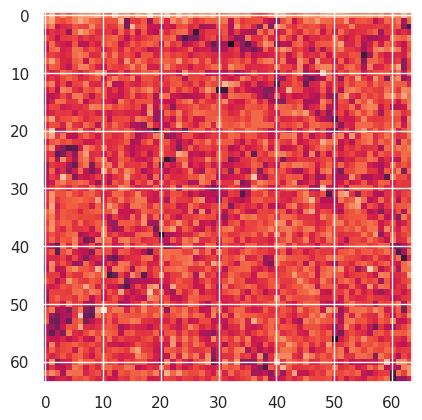

In [59]:

plt.imshow(z_out[0][0].cpu().detach().numpy())  # Channel 0
plt.imshow(z_out[0][1].cpu().detach().numpy())  # Channel 0
plt.imshow(z_out[0][62].cpu().detach().numpy())  # Channel 0